## Lecture 7. CNN-1 
  (1) Fashion MNIST 데이터를 처리하는 CNN 모델을 만든다.\
  (2) 학습데이터에 대한 epoch에 따른 cross-entropy loss와 accuracy 그래프를 그린다.\
  (3) 테스트 데이터에 대한 인식률을 그린다,

Step 0. 설정

In [37]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch.nn.functional as F

import random
import numpy as np

from utilities import EarlyStopping

In [38]:
L_R = 1e-3
BATCH_SIZE = 100
EPOCHS = 30

In [39]:
if torch.cuda.is_available()==True:
  DEVICE='cuda'
else:
  DEVICE='cpu'
np.random.seed(0b011011)
random.seed(0b011011)
torch.manual_seed(0b011011)
if DEVICE == 'cuda':
  torch.cuda.manual_seed_all(0b011011)


print("You are using '{}' as a device.".format(DEVICE))

You are using 'cuda' as a device.


Step 1. Data

In [40]:
train_data = datasets.FashionMNIST(
    root="F:\Python_Codes\Data_for_Practice", 
    train=True, 
    download=True, 
    transform=ToTensor()
    )



test_data= datasets.FashionMNIST(
    root="F:\Python_Codes\Data_for_Practice", 
    train=False, 
    download=True, 
    transform=ToTensor()
    )


train_data, val_data=torch.utils.data.random_split(train_data, [50000,10000])

In [41]:
train_dataloader =DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader =DataLoader(val_data)
test_dataloader =DataLoader(test_data)

In [42]:
class CNN(nn.Module):
#nn.Module을 서브클래스로 두면서 NN을 정의하고, __init__에서 NN layers을 초기화한다.
	def __init__(self, drop_prob=0.5):
		self.drop_prob=drop_prob
	#init에서는 모델을 초기화하고, 모델 구조 정의가 이루어진다.
		super(CNN, self).__init__()
		self.conv1=nn.Sequential(
            nn.Conv2d(1,32,kernel_size=3,stride=1,padding=1),
			nn.ReLU(),
			nn.MaxPool2d(2)
        )
		self.conv2=nn.Sequential(
			nn.Conv2d(32,64,3,stride=1, padding=1),
			nn.ReLU(),
			nn.MaxPool2d(2)
		)
		self.conv3=nn.Sequential(
			nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
			nn.ReLU(),
			nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
		)

		self.fc1=nn.Sequential(
			nn.Linear(4*4*128,4*128),
			nn.ReLU(),
			#nn.Dropout(p=drop_prob)
		)

		self.fc2=nn.Sequential(
			nn.Linear(4*128,10)
		)
	def forward(self, x):
	#forward에서는 실행 정의가 이루어진다. 즉 NN의 결과를 계산한다.
		x=self.conv1(x)
		x=self.conv2(x)
		x=self.conv3(x)

		x=x.view(x.size(0), -1)
		x=self.fc1(x)
		x=self.fc2(x)
		return x


model=CNN().to(DEVICE)

Step 3 and 4. Loss Function and Optimization

In [43]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=L_R)

Train Loop, Test Loop, and Train Model

In [44]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    data_num=len(dataloader.dataset)
    batch_num=len(dataloader)
    train_loss=0
    train_correct=0

    for batchs, (X,Y) in enumerate(train_dataloader):
        optimizer.zero_grad()

        X=X.to(DEVICE)
        Y=Y.to(DEVICE)

        Y_hat=model(X)
        loss=loss_fn(Y_hat, Y)
        loss.backward()
        optimizer.step()

        train_correct+= (Y_hat.argmax(1) == Y).type(torch.float).sum().item()
        train_loss+=loss.item()

    train_loss/=batch_num
    train_acc = train_correct/data_num
    return train_loss, train_acc

In [45]:
def test_loop(dataloader, model, loss_fn):
    model.eval()
    data_num=len(dataloader.dataset)
    batch_num=len(dataloader)
    test_loss=0
    test_correct=0

    with torch.no_grad():
        for batchs, (X,Y) in enumerate(dataloader):
            X=X.to(DEVICE)
            Y=Y.to(DEVICE)

            Y_hat=model(X)
            
            loss=loss_fn(Y_hat, Y)
            test_correct+=(Y_hat.argmax(1)==Y).type(torch.float).sum().item()
            test_loss += loss.item()
    
    test_loss/=batch_num
    test_acc = test_correct/data_num

    return test_loss, test_acc

In [46]:
def train_model():
    early_stopping=EarlyStopping(patience=7, verbose=True)
    train_loss_list=[]
    train_acc_list=[]
    val_loss_list=[]
    val_acc_list=[]
    
    exe_epoch=0

    for epoch in range(EPOCHS):
        exe_epoch+=1

        print(f"\n{epoch+1}번째 Epoch", end="  ")

        train_loss, train_acc= train_loop(train_dataloader, model, loss_fn, optimizer)
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        print(f"\nTrain - avg Loss= {train_loss:>8f},  Accuracy: {(100*train_acc):>0.1f}%", end = "  ")
        
        val_loss, val_acc=test_loop(val_dataloader,model,loss_fn)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)

        print(f"\nVal - avg Loss= {val_loss:>8f},  Accuracy: {(100*val_acc):>0.1f}%\n", end = "  ")

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early Stop!")
            break

        model.load_state_dict(torch.load('checkpoint.pt'))
    
    print("Done!")
    return train_loss_list, train_acc_list, val_loss_list, val_acc_list, exe_epoch

In [47]:
train_loss, train_acc, val_loss, val_acc, exe_epoch = train_model()


1번째 Epoch  
Train - avg Loss= 0.535860,  Accuracy: 80.2%  
Val - avg Loss= 0.403763,  Accuracy: 85.0%
  Validation loss decreased (inf --> 0.403763).  Saving model ...

2번째 Epoch  
Train - avg Loss= 0.319076,  Accuracy: 88.3%  
Val - avg Loss= 0.310015,  Accuracy: 88.8%
  Validation loss decreased (0.403763 --> 0.310015).  Saving model ...

3번째 Epoch  
Train - avg Loss= 0.264073,  Accuracy: 90.2%  
Val - avg Loss= 0.265390,  Accuracy: 90.6%
  Validation loss decreased (0.310015 --> 0.265390).  Saving model ...

4번째 Epoch  
Train - avg Loss= 0.236128,  Accuracy: 91.3%  
Val - avg Loss= 0.242310,  Accuracy: 90.8%
  Validation loss decreased (0.265390 --> 0.242310).  Saving model ...

5번째 Epoch  
Train - avg Loss= 0.208796,  Accuracy: 92.2%  
Val - avg Loss= 0.225451,  Accuracy: 91.4%
  Validation loss decreased (0.242310 --> 0.225451).  Saving model ...

6번째 Epoch  
Train - avg Loss= 0.186197,  Accuracy: 93.1%  
Val - avg Loss= 0.229513,  Accuracy: 91.7%
  EarlyStopping counter: 1 out o

Figure

In [48]:
print(train_loss)

[0.5358597403168678, 0.31907644495368004, 0.26407304783165453, 0.23612768914550541, 0.20879564256966113, 0.1861971212401986, 0.18686417146772147, 0.16740894837677478, 0.16819851883500814, 0.1670296624675393, 0.16796035635471343, 0.16782114274799823, 0.1686511994153261, 0.16808413538336753]


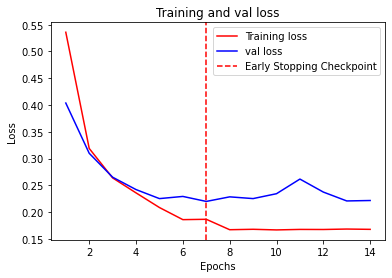

In [56]:
epochs=np.arange(1,exe_epoch+1)
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='val loss')

minposs = val_loss.index(min(val_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.title('Training and val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

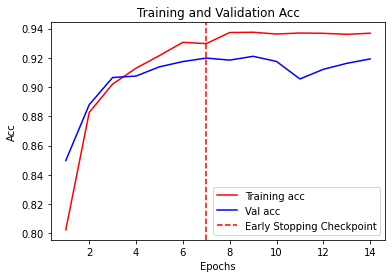

In [57]:
plt.clf()   # 그래프를 초기화합니다
plt.plot(epochs, train_acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Val acc')

minposs = val_loss.index(min(val_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.title('Training and Validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()

5. Test

In [58]:
test_loss, test_acc= test_loop(test_dataloader, model, loss_fn)
print(f"\nTest - avg Loss= {test_loss:>8f},  Accuracy: {(100*test_acc):>0.1f}%\n", end = "  ")


Test - avg Loss= 0.241537,  Accuracy: 91.1%
  